### Importing modules

In [27]:
import json
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np; np.random.seed(159)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co
from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, MinMaxScaler as mms
from sklearn.metrics import accuracy_score as acc, classification_report as cr, confusion_matrix as cm, precision_score as ps, r2_score as r2, recall_score as rs
from sklearn.model_selection import cross_val_score as cvs
from imblearn.under_sampling import RandomUnderSampler

from Classification import Classifier, plot_lc_model_comparison
from NeuralNetwork import execute_neural_net, plot_learning_curve, plot_learning_curve_comparison
import torch
import torch.nn as nn

---

# Loading Clean Data

In [2]:
data = pd.read_csv('data/drug_use_clean.csv')

In [3]:
cols = {
    'socio': data.columns[1:6].tolist(),
    'psych': data.columns[6:13].tolist(),
    'drugs': data.columns[13:].tolist(),
}

#### Loading categories dictionaries

In [4]:
with open('DrugConsumptionClasses.json', 'r') as file:
    cls_dict = json.load(file)
cls_dict

{'CL0': 'Never Used',
 'CL1': 'Used over a Decade Ago',
 'CL2': 'Used in Last Decade',
 'CL3': 'Used in Last Year',
 'CL4': 'Used in Last Month',
 'CL5': 'Used in Last Week',
 'CL6': 'Used in Last Day'}

---

# DATA TRANSFORMATION

# Target variable binary transformation

In [5]:
target = 'Cannabis'
features = cols['socio'] + cols['psych']

In [6]:
Y = Classifier.binary_target(data[target], class_0=['CL0', 'CL1', 'CL2'], name=target+' Ever', invert=True)

In [7]:
Y.value_counts().to_frame()

,Cannabis Ever
0,999
1,885


# Feature data transformation

#### Label encoding psychological features

In [8]:
X = data[features].copy()

# Label Encoding -----------------------------
for col in cols['socio']:  
    X[col] = le().fit_transform(X[col])    

#### Scaling features

In [9]:
X_norm = X.copy(); X_max = X.copy()

# Standard Normalizaiton -----------------------------------------------
X_norm[cols['socio']] = ss().fit_transform(X_norm[cols['socio']])
# MinMax Scaling -----------------------------------------------
X_max[cols['socio']] = mms().fit_transform(X_max[cols['socio']])

---
# DATA SAMPLING

# Undersampling majority class

In [10]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
x, y = undersample.fit_resample(X, Y)

# Train test split

In [11]:
xt, xe, yt, ye = tts(x, y, test_size=0.2, random_state=999)

---
# BINARY CASSIFICATION MODELS
# Evaluating train test split for multiple metrics and models

In [17]:
models = [
    'AdaBoostClassifier','BaggingClassifier', 'DecisionTreeClassifier',
    'ExtraTreesClassifier','GaussianProcessClassifier', 'GradientBoostingClassifier',
    'HistGradientBoostingClassifier','KNeighborsClassifier','LinearDiscriminantAnalysis',
    'LinearSVC','LogisticRegression', 'LogisticRegressionCV', 'NearestCentroid',
    'RandomForestClassifier','RidgeClassifier', 'RidgeClassifierCV','SGDClassifier', 'SVC'
#     'DummyClassifier', 'RadiusNeighborsClassifier',
]

In [102]:
scrs = Classifier().scr(models, xt, yt, xe, ye, scoring=['accuracy', 'precision', 'recall'])
scrs.sort_values('accuracy', ascending=False).head(6)

SVC


,accuracy,precision,recall
GradientBoostingClassifier,0.847458,0.859649,0.830508
RandomForestClassifier,0.838983,0.830409,0.835294
ExtraTreesClassifier,0.833333,0.842105,0.818182
AdaBoostClassifier,0.824859,0.836257,0.807910
HistGradientBoostingClassifier,0.816384,0.830409,0.797753
GaussianProcessClassifier,0.810734,0.836257,0.785714


# Multiple model evaluation using cross validation

In [22]:
cv_scrs = Classifier().cv_scr(models, x, y, cv=10)
co(wait=True); cv_scrs.loc['mean'].sort_values(ascending=False)

GradientBoostingClassifier        0.812994
AdaBoostClassifier                0.804520
ExtraTreesClassifier              0.801695
RandomForestClassifier            0.800565
SVC                               0.800000
HistGradientBoostingClassifier    0.796045
LogisticRegression                0.788136
LinearDiscriminantAnalysis        0.788136
RidgeClassifier                   0.787571
RidgeClassifierCV                 0.786441
LinearSVC                         0.783051
LogisticRegressionCV              0.781921
GaussianProcessClassifier         0.781356
BaggingClassifier                 0.772316
KNeighborsClassifier              0.771751
NearestCentroid                   0.765537
DecisionTreeClassifier            0.728814
SGDClassifier                     0.722599
Name: mean, dtype: float64

#### Selecting best performing models based on cross validation

In [23]:
top_models = cv_scrs.loc['mean'].sort_values(ascending=False).head(10).index.tolist()

top_models = [
    'GradientBoostingClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier',
    'HistGradientBoostingClassifier', 'SVC', 'AdaBoostClassifier', 'RidgeClassifier',
    'LinearDiscriminantAnalysis', 'LogisticRegression', 'RidgeClassifierCV'
]

# Baseline classifier cross validation

In [24]:
classifiers = dict(all_estimators('classifier'))
model_name = 'GradientBoostingClassifier'
model = classifiers[model_name]

In [25]:
cv_scrs = cvs(model(), x, y, cv=10)
co(wait=True); pd.Series(cv_scrs).describe()

count    10.000000
mean      0.813559
std       0.062403
min       0.689266
25%       0.775424
50%       0.836158
75%       0.855932
max       0.898305
dtype: float64

### Classification report on unseen data

In [26]:
yp = model().fit(xt, yt).predict(xe)

print(cr(ye, yp))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       183
           1       0.83      0.86      0.84       171

    accuracy                           0.84       354
   macro avg       0.84      0.85      0.84       354
weighted avg       0.85      0.84      0.84       354



### Confusion Matrix

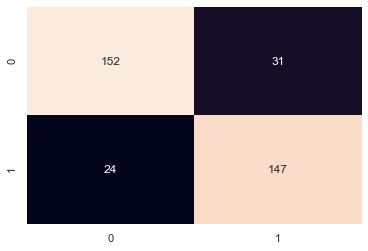

In [38]:
sns.heatmap(cm(ye, yp), annot=True, cbar=False, fmt='.0f')

# Visualizing selected models test data learning curves 

In [14]:
train_size_scrs = Classifier().train_size_scr(
    top_models, xt, yt, xe, ye,
    batch_size=10, n=None, order=None,
    scoring=['accuracy', 'precision', 'recall']
)

RidgeClassifierCV


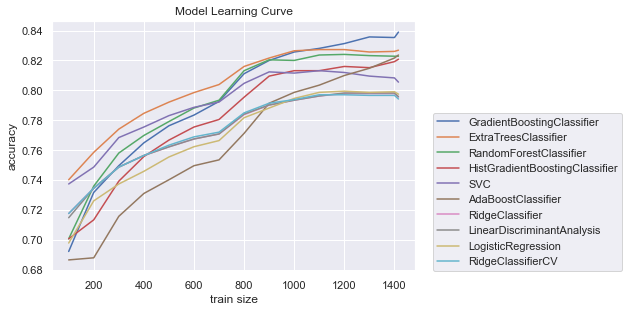

In [95]:
plot_lc_model_comparison(
    train_size_scrs, metric='accuracy',
    avg_window=7, min_periods=1, center=False,
    figsize=(9, 4.5), legend=True, leg_loc=(1.05, 0),
    title='Model Learning Curve', tight_layout=True, path=None
)

---
# Feature selection and evaluation

In [39]:
model_name = 'GradientBoostingClassifier'
model = classifiers[model_name]

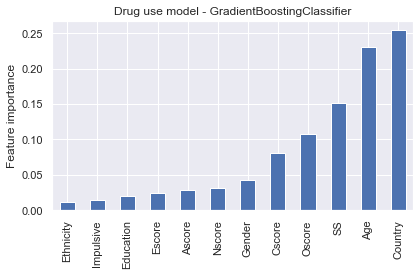

In [54]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
feature_importance = pd.Series(model().fit(xt, yt).feature_importances_, index=X.columns).sort_values()
feature_importance.plot.bar(ax=ax); plt.title(f'Drug use model - {model_name}'); plt.ylabel('Feature importance'); plt.show()

In [79]:
selected_features = feature_importance[:12].index.values
yp_sel = model().fit(xt[selected_features], yt).predict(xe[selected_features])

print(cr(ye, yp_sel))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       183
           1       0.83      0.86      0.84       171

    accuracy                           0.84       354
   macro avg       0.84      0.85      0.84       354
weighted avg       0.85      0.84      0.84       354



---
# BINARY CLASSIFICATION MODELING USING NEURAL NETWORKS

In [106]:
nn_params = {
    'test_size': 0.3,
    'hidden_layers': [432],
    'initial_params': {'weight': 0, 'bias': 0},
    # 'criterion': None
    'optimizer': torch.optim.SGD,
    'activation': 'sigmoid',
    'epochs': 300,
    'batch_size': 20,
    'lr': 0.1,
    'momentum': 0.1,
}

criteria_dict = {
    'BCELoss': nn.BCELoss,
    'L1Loss': nn.L1Loss,
    'MSELoss': nn.MSELoss,
    'HuberLoss': nn.HuberLoss
}

eval_i = {}
for label, criteria in criteria_dict.items():
    eval_i[label] = execute_neural_net(
        xt, yt, xe, ye,
        criterion=criteria,
        **nn_params,
    )

Epoch: 300/300


### Comparing neural network test predictions for different loss functions

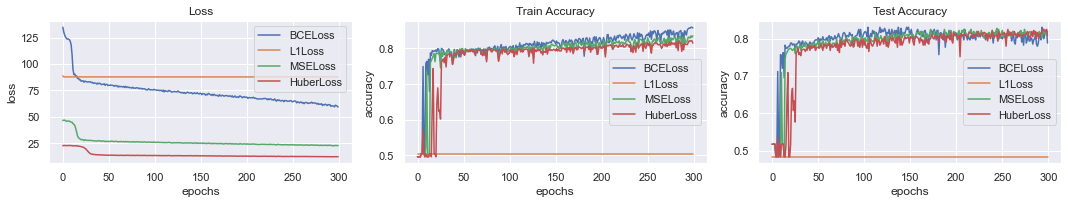

In [104]:
plot_learning_curve_comparison(eval_i, figsize=(15,3), tight_layout=True, legend=True)

In [ ]:
[108]

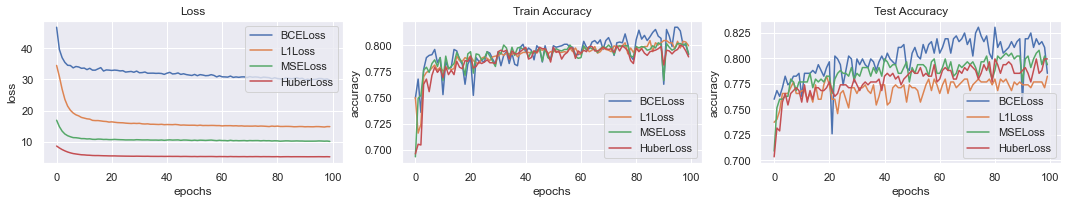

In [101]:
plot_learning_curve_comparison(eval_i, figsize=(15,3), tight_layout=True, legend=True)